# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline

import torch
import numpy as np
from torch import optim
import torchvision.utils
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split

import config
from utils import imshow
from models import SiameseNetwork
from training import trainSiamese,inferenceSiamese
from datasets import SiameseNetworkDataset
from loss_functions import ContrastiveLoss

# generate_csv(config.training_dir)

import os
if not os.path.exists('state_dict'):
    os.makedirs('state_dict')

## Using Image Folder Dataset

In [2]:
siamese_dataset = SiameseNetworkDataset(training_dir=config.training_dir,
                                        training_csv=config.siamese_training_csv,
                                        transform=transforms.Compose([transforms.Resize((config.img_height,config.img_width)),
                                                                      transforms.ToTensor(),
                                                                      transforms.Normalize(0,1)
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

In [3]:
# vis_dataloader = DataLoader(siamese_dataset,
#                         shuffle=True,
#                         num_workers=1,
#                         batch_size=8)

# dataiter = iter(vis_dataloader)

# example_batch = next(dataiter)

# concatenated = torch.cat((example_batch[0],example_batch[1]),0)
# imshow(torchvision.utils.make_grid(concatenated))
# print(example_batch[2].numpy())

## Training Time!

In [4]:
# Split the dataset into train, validation and test sets
num_train = round(0.9*siamese_dataset.__len__())
num_validate = siamese_dataset.__len__()-num_train
siamese_train, siamese_valid = random_split(siamese_dataset, [num_train,num_validate])
train_dataloader = DataLoader(siamese_train,
                        shuffle=True,
                        num_workers=8,
                        batch_size=config.train_batch_size)
valid_dataloader = DataLoader(siamese_valid,
                        shuffle=True,
                        num_workers=8,
                        batch_size=1)

In [5]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = config.learning_rate )
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,config.step_size, config.gamma)

Epoch  0  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 26.36it/s]


Epoch  0  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 215.12it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:1.71	 min:0.04	 mean:0.37	 median 0.31
-1 features max:2.00	 min:0.20	 mean:0.89	 median 0.88
Epoch-0	 Train loss: 0.1059	 Valid loss: 0.1481	 Valid error: 0.1471
Epoch  1  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 31.22it/s]


Epoch  1  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 219.94it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.71	 min:0.03	 mean:0.26	 median 0.24
-1 features max:2.31	 min:0.38	 mean:1.22	 median 1.09
Epoch-1	 Train loss: 0.0333	 Valid loss: 0.0560	 Valid error: 0.0300
new model saved
Epoch  2  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 31.32it/s]


Epoch  2  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 219.41it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.58	 min:0.02	 mean:0.21	 median 0.19
-1 features max:2.77	 min:0.34	 mean:1.38	 median 1.29
Epoch-2	 Train loss: 0.0166	 Valid loss: 0.0392	 Valid error: 0.0120
new model saved
Epoch  3  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 31.12it/s]


Epoch  3  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 218.70it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.90	 min:0.04	 mean:0.22	 median 0.17
-1 features max:2.94	 min:0.57	 mean:1.53	 median 1.42
Epoch-3	 Train loss: 0.0089	 Valid loss: 0.0417	 Valid error: 0.0180
new model saved
Epoch  4  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.54it/s]


Epoch  4  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 219.37it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.53	 min:0.03	 mean:0.19	 median 0.16
-1 features max:3.13	 min:0.62	 mean:1.60	 median 1.49
Epoch-4	 Train loss: 0.0057	 Valid loss: 0.0299	 Valid error: 0.0000
new model saved
Epoch  5  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 31.38it/s]


Epoch  5  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 216.07it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.17	 median 0.15
-1 features max:3.15	 min:0.61	 mean:1.56	 median 1.42
Epoch-5	 Train loss: 0.0051	 Valid loss: 0.0249	 Valid error: 0.0000
new model saved
Epoch  6  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 31.06it/s]


Epoch  6  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 222.70it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.65	 min:0.03	 mean:0.17	 median 0.15
-1 features max:2.98	 min:0.45	 mean:1.56	 median 1.48
Epoch-6	 Train loss: 0.0050	 Valid loss: 0.0249	 Valid error: 0.0030
new model saved
Epoch  7  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 31.10it/s]


Epoch  7  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 210.78it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.52	 min:0.03	 mean:0.16	 median 0.14
-1 features max:2.96	 min:0.51	 mean:1.55	 median 1.48
Epoch-7	 Train loss: 0.0063	 Valid loss: 0.0214	 Valid error: 0.0030
new model saved
Epoch  8  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 31.29it/s]


Epoch  8  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 220.22it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.54	 min:0.02	 mean:0.16	 median 0.14
-1 features max:3.07	 min:0.57	 mean:1.57	 median 1.53
Epoch-8	 Train loss: 0.0029	 Valid loss: 0.0223	 Valid error: 0.0000
new model saved
Epoch  9  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.90it/s]


Epoch  9  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 203.83it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.47	 min:0.02	 mean:0.15	 median 0.12
-1 features max:3.06	 min:0.57	 mean:1.62	 median 1.60
Epoch-9	 Train loss: 0.0051	 Valid loss: 0.0202	 Valid error: 0.0000
new model saved
Epoch  10  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.54it/s]


Epoch  10  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 197.60it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.46	 min:0.02	 mean:0.14	 median 0.12
-1 features max:3.05	 min:0.57	 mean:1.61	 median 1.54
Epoch-10	 Train loss: 0.0013	 Valid loss: 0.0184	 Valid error: 0.0000
new model saved
Epoch  11  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.63it/s]


Epoch  11  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 201.74it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.47	 min:0.02	 mean:0.14	 median 0.11
-1 features max:3.08	 min:0.61	 mean:1.63	 median 1.57
Epoch-11	 Train loss: 0.0012	 Valid loss: 0.0176	 Valid error: 0.0000
new model saved
Epoch  12  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.65it/s]


Epoch  12  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 204.60it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.48	 min:0.02	 mean:0.14	 median 0.11
-1 features max:3.08	 min:0.61	 mean:1.63	 median 1.58
Epoch-12	 Train loss: 0.0019	 Valid loss: 0.0175	 Valid error: 0.0000
new model saved
Epoch  13  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.16it/s]


Epoch  13  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 207.24it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.50	 min:0.02	 mean:0.14	 median 0.11
-1 features max:3.11	 min:0.59	 mean:1.64	 median 1.57
Epoch-13	 Train loss: 0.0008	 Valid loss: 0.0173	 Valid error: 0.0000
new model saved
Epoch  14  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.62it/s]


Epoch  14  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 203.54it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.50	 min:0.02	 mean:0.14	 median 0.11
-1 features max:3.14	 min:0.60	 mean:1.65	 median 1.57
Epoch-14	 Train loss: 0.0012	 Valid loss: 0.0170	 Valid error: 0.0000
new model saved
Epoch  15  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.61it/s]


Epoch  15  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 203.77it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.14	 median 0.11
-1 features max:3.12	 min:0.60	 mean:1.65	 median 1.59
Epoch-15	 Train loss: 0.0022	 Valid loss: 0.0173	 Valid error: 0.0000
new model saved
Epoch  16  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 31.03it/s]


Epoch  16  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 210.80it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.50	 min:0.01	 mean:0.14	 median 0.11
-1 features max:3.15	 min:0.61	 mean:1.66	 median 1.59
Epoch-16	 Train loss: 0.0009	 Valid loss: 0.0173	 Valid error: 0.0000
new model saved
Epoch  17  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 31.12it/s]


Epoch  17  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 209.09it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.14	 median 0.11
-1 features max:3.12	 min:0.56	 mean:1.66	 median 1.59
Epoch-17	 Train loss: 0.0014	 Valid loss: 0.0166	 Valid error: 0.0000
new model saved
Epoch  18  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.79it/s]


Epoch  18  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 212.10it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.14	 median 0.11
-1 features max:3.12	 min:0.61	 mean:1.66	 median 1.59
Epoch-18	 Train loss: 0.0017	 Valid loss: 0.0171	 Valid error: 0.0000
Epoch  19  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 31.10it/s]


Epoch  19  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 211.69it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.48	 min:0.02	 mean:0.14	 median 0.11
-1 features max:3.12	 min:0.57	 mean:1.66	 median 1.58
Epoch-19	 Train loss: 0.0007	 Valid loss: 0.0165	 Valid error: 0.0000
new model saved
Epoch  20  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.57it/s]


Epoch  20  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 210.26it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.14	 median 0.11
-1 features max:3.12	 min:0.58	 mean:1.66	 median 1.59
Epoch-20	 Train loss: 0.0015	 Valid loss: 0.0166	 Valid error: 0.0000
Epoch  21  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.89it/s]


Epoch  21  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 214.98it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.01	 mean:0.13	 median 0.11
-1 features max:3.11	 min:0.57	 mean:1.66	 median 1.59
Epoch-21	 Train loss: 0.0016	 Valid loss: 0.0162	 Valid error: 0.0000
new model saved
Epoch  22  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.61it/s]


Epoch  22  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 204.82it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.10	 min:0.57	 mean:1.66	 median 1.59
Epoch-22	 Train loss: 0.0005	 Valid loss: 0.0162	 Valid error: 0.0000
new model saved
Epoch  23  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.97it/s]


Epoch  23  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 212.03it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.11	 min:0.58	 mean:1.66	 median 1.59
Epoch-23	 Train loss: 0.0006	 Valid loss: 0.0162	 Valid error: 0.0000
Epoch  24  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.86it/s]


Epoch  24  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 206.80it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.10	 min:0.58	 mean:1.66	 median 1.59
Epoch-24	 Train loss: 0.0004	 Valid loss: 0.0161	 Valid error: 0.0000
new model saved
Epoch  25  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 31.02it/s]


Epoch  25  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 209.41it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.10	 min:0.58	 mean:1.66	 median 1.60
Epoch-25	 Train loss: 0.0004	 Valid loss: 0.0162	 Valid error: 0.0000
new model saved
Epoch  26  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 31.04it/s]


Epoch  26  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 205.68it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.11	 min:0.58	 mean:1.66	 median 1.59
Epoch-26	 Train loss: 0.0004	 Valid loss: 0.0162	 Valid error: 0.0000
new model saved
Epoch  27  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.91it/s]


Epoch  27  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 213.70it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.10	 min:0.59	 mean:1.66	 median 1.60
Epoch-27	 Train loss: 0.0003	 Valid loss: 0.0160	 Valid error: 0.0000
new model saved
Epoch  28  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 31.13it/s]


Epoch  28  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 207.48it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.50	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.11	 min:0.58	 mean:1.66	 median 1.60
Epoch-28	 Train loss: 0.0006	 Valid loss: 0.0162	 Valid error: 0.0000
Epoch  29  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.85it/s]


Epoch  29  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 208.32it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.10	 min:0.58	 mean:1.66	 median 1.60
Epoch-29	 Train loss: 0.0009	 Valid loss: 0.0162	 Valid error: 0.0000
Epoch  30  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 31.14it/s]


Epoch  30  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 211.44it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.10	 min:0.58	 mean:1.66	 median 1.60
Epoch-30	 Train loss: 0.0008	 Valid loss: 0.0161	 Valid error: 0.0000
Epoch  31  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.94it/s]


Epoch  31  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 214.79it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.10	 min:0.58	 mean:1.66	 median 1.60
Epoch-31	 Train loss: 0.0019	 Valid loss: 0.0162	 Valid error: 0.0000
Epoch  32  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.75it/s]


Epoch  32  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 203.77it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.10	 min:0.58	 mean:1.66	 median 1.60
Epoch-32	 Train loss: 0.0006	 Valid loss: 0.0161	 Valid error: 0.0000
Epoch  33  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.89it/s]


Epoch  33  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 205.74it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.10	 min:0.58	 mean:1.66	 median 1.60
Epoch-33	 Train loss: 0.0007	 Valid loss: 0.0161	 Valid error: 0.0000
Epoch  34  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.64it/s]


Epoch  34  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 210.34it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.10	 min:0.58	 mean:1.66	 median 1.60
Epoch-34	 Train loss: 0.0008	 Valid loss: 0.0161	 Valid error: 0.0000
Epoch  35  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 31.27it/s]


Epoch  35  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 212.20it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.09	 min:0.58	 mean:1.66	 median 1.60
Epoch-35	 Train loss: 0.0005	 Valid loss: 0.0161	 Valid error: 0.0000
Epoch  36  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.98it/s]


Epoch  36  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 214.78it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.10	 min:0.58	 mean:1.66	 median 1.59
Epoch-36	 Train loss: 0.0001	 Valid loss: 0.0161	 Valid error: 0.0000
new model saved
Epoch  37  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.96it/s]


Epoch  37  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 209.82it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.10	 min:0.58	 mean:1.66	 median 1.60
Epoch-37	 Train loss: 0.0002	 Valid loss: 0.0161	 Valid error: 0.0000
Epoch  38  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.78it/s]


Epoch  38  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 205.20it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.09	 min:0.58	 mean:1.66	 median 1.60
Epoch-38	 Train loss: 0.0004	 Valid loss: 0.0160	 Valid error: 0.0000
new model saved
Epoch  39  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 31.14it/s]


Epoch  39  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 215.23it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.09	 min:0.58	 mean:1.66	 median 1.60
Epoch-39	 Train loss: 0.0006	 Valid loss: 0.0160	 Valid error: 0.0000
Epoch  40  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.78it/s]


Epoch  40  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 211.17it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.09	 min:0.58	 mean:1.66	 median 1.60
Epoch-40	 Train loss: 0.0006	 Valid loss: 0.0160	 Valid error: 0.0000
Epoch  41  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.64it/s]


Epoch  41  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 208.98it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.10	 min:0.58	 mean:1.66	 median 1.60
Epoch-41	 Train loss: 0.0006	 Valid loss: 0.0160	 Valid error: 0.0000
Epoch  42  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.39it/s]


Epoch  42  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 206.66it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.10	 min:0.58	 mean:1.66	 median 1.60
Epoch-42	 Train loss: 0.0002	 Valid loss: 0.0160	 Valid error: 0.0000
Epoch  43  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 31.14it/s]


Epoch  43  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 214.41it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.10	 min:0.58	 mean:1.66	 median 1.60
Epoch-43	 Train loss: 0.0004	 Valid loss: 0.0160	 Valid error: 0.0000
Epoch  44  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.97it/s]


Epoch  44  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 218.28it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.10	 min:0.58	 mean:1.66	 median 1.60
Epoch-44	 Train loss: 0.0012	 Valid loss: 0.0160	 Valid error: 0.0000
Epoch  45  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.94it/s]


Epoch  45  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 215.94it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.10	 min:0.58	 mean:1.66	 median 1.60
Epoch-45	 Train loss: 0.0003	 Valid loss: 0.0160	 Valid error: 0.0000
Epoch  46  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 31.06it/s]


Epoch  46  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 212.44it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.10	 min:0.58	 mean:1.66	 median 1.60
Epoch-46	 Train loss: 0.0002	 Valid loss: 0.0160	 Valid error: 0.0000
Epoch  47  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.79it/s]


Epoch  47  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 219.90it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.10	 min:0.58	 mean:1.66	 median 1.60
Epoch-47	 Train loss: 0.0001	 Valid loss: 0.0160	 Valid error: 0.0000
new model saved
Epoch  48  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 31.09it/s]


Epoch  48  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 211.10it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.10	 min:0.58	 mean:1.66	 median 1.60
Epoch-48	 Train loss: 0.0002	 Valid loss: 0.0160	 Valid error: 0.0000
Epoch  49  training


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 30.65it/s]


Epoch  49  validating


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 213.96it/s]


+1/-1 ratrio:0.52/0.48
+1 features max:0.49	 min:0.02	 mean:0.13	 median 0.11
-1 features max:3.10	 min:0.58	 mean:1.66	 median 1.60
Epoch-49	 Train loss: 0.0004	 Valid loss: 0.0160	 Valid error: 0.0000


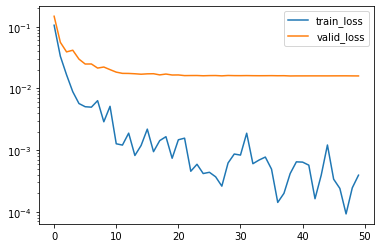

In [6]:
net, train_loss_history, valid_loss_history,dict_name = trainSiamese(net,criterion,optimizer,scheduler,train_dataloader,
             valid_dataloader,config.train_number_epochs,do_show=True)

## Testing

100%|████████████████████████████████████████| 269/269 [00:01<00:00, 191.99it/s]


+1/-1 ratrio:0.50/0.50
+1 features max:1.59	 min:0.07	 mean:0.58	 median 0.34
-1 features max:1.80	 min:0.36	 mean:1.06	 median 1.17
Test loss: 0.3078	 Test error: 0.2156


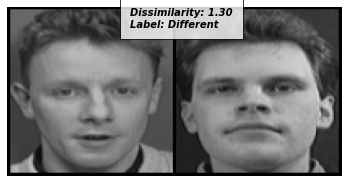

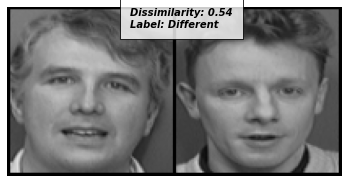

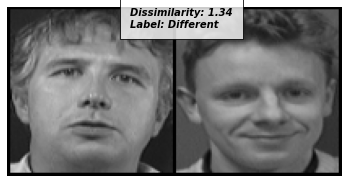

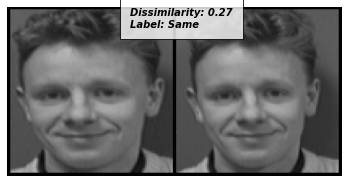

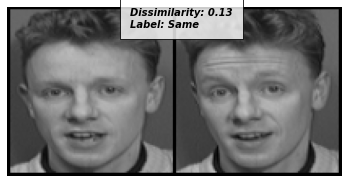

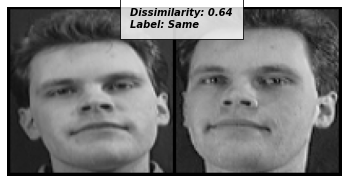

In [8]:
net = SiameseNetwork().cuda()
net.load_state_dict(torch.load(os.path.join("state_dict",dict_name)))
net.eval()

siamese_test = SiameseNetworkDataset(training_dir=config.testing_dir,
                                        training_csv=config.siamese_testing_csv,
                                        transform=transforms.Compose([transforms.Resize((config.img_height,config.img_width)),
                                                                      transforms.ToTensor(),
                                                                      transforms.Normalize(0,1)
                                                                      ])
                                       ,should_invert=False)
test_dataloader = DataLoader(siamese_test,num_workers=8,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)

test_loss, test_er = inferenceSiamese(net,criterion,test_dataloader)
print("Test loss: %.4f\t Test error: %.4f"
      %(test_loss, test_er))


for i in range(3):
    label = 0
    while label == 0:
        x0,x1,label = next(dataiter)
        label = label.detach().cpu().numpy()[0][0]

    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}\nLabel: {}'.format(euclidean_distance.item(),'Different'))

for i in range(3):
    label = 1
    while label == 1:
        x0,x1,label = next(dataiter)
        label = label.detach().cpu().numpy()[0][0]

    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}\nLabel: {}'.format(euclidean_distance.item(),'Same'))

